In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas
from torch.utils.data import DataLoader,Dataset, random_split, Subset
from matplotlib.pylab import plt
import warnings

from torchmetrics.classification import BinaryAccuracy
import os
import shutil
from util_FPC import EarlyStopping


warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
discharge_capacities_data = np.load(r"./Datasets/discharge_capacity.npy", allow_pickle=True)
discharge_capacities_data = discharge_capacities_data.tolist()

np.array(discharge_capacities_data[0]).shape

(7, 1851)

In [4]:
discharge_capacities = [np.array(battery)[0] for battery in discharge_capacities_data]   # Taking only 1 channel for prediction ]

# plt.plot(data[0])

In [5]:
lengths = [len(battery) for battery in discharge_capacities]
max_length = max(lengths)   # Finding maximum cycle length

cell_with_max_cycle_life = np.argmax(lengths)
print("Cell with Maximum length :", cell_with_max_cycle_life)

print("Maximum cycle length :", max_length)
percentage = 0.4                                                      # Percentage of data for training
max_length_train = int(percentage*max_length)                         # maximum length for training
max_length_out  = max_length- max_length_train                        # maximum length of the output

print("Maximum Length for training X:", max_length_train)
print("Maximum Length of output     :", max_length_out)

Cell with Maximum length : 2
Maximum cycle length : 2236
Maximum Length for training X: 894
Maximum Length of output     : 1342


In [6]:
class battery_dataloader(Dataset):
    
    def __init__(self,data):
        self.data = data
    

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        
        inp =  torch.tensor(self.data[idx][0]).float()
        output = torch.tensor(self.data[idx][1]).float()
       
        return inp, output

In [7]:
# X_padded = []
# Y_padded = []
# data = []
# for i in range(len(discharge_capacities)):
    
#     number_of_cycles_train = int(len(discharge_capacities[i])*percentage)   # getting some percentage of data for the training 
#     number_of_cycles_out  = len(discharge_capacities[i]) - int(len(discharge_capacities[i])*percentage)  # remaining data is the output

#     # right padding is done in both input and outputs
#     X_padded = np.pad(discharge_capacities[i][:number_of_cycles_train], (0,max_length_train-number_of_cycles_train),'constant', constant_values=(-0.1))
#     Y_padded = np.pad(discharge_capacities[i][number_of_cycles_train:], (0,max_length_out-number_of_cycles_out),'constant', constant_values=(-0.1))
#     data.append((X_padded,Y_padded))

# print("X is padded to ", np.array(X_padded).shape[0])
# print("Y is padded to ", np.array(Y_padded).shape[0])

# obj_train  = battery_dataloader(data[0:100])
# obj_test  = battery_dataloader(data[100:])



# train_dataloader = DataLoader(obj_train, batch_size=8,shuffle=True)
# test_dataloader = DataLoader(obj_test, batch_size=1,shuffle=False)





In [8]:
X_train_padded = []
Y_train_padded = []
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)), (max(data), min(data))

for i in range(len(discharge_capacities)):
    
    number_of_cycles_train = int(len(discharge_capacities[i])*percentage)   # getting some percentage of data for the training 
    number_of_cycles_out  = len(discharge_capacities[i]) - int(len(discharge_capacities[i])*percentage)  # remaining data is the output

    # right padding is done in both input and outputs
    X_train_padded.append(np.pad(discharge_capacities[i][:number_of_cycles_train], (0,max_length_train-number_of_cycles_train),'constant', constant_values=(-0.1)))
    
    
    Y_train_padded.append(np.pad(NormalizeData(discharge_capacities[i][number_of_cycles_train:])[0], (0,max_length_out-number_of_cycles_out),'constant', constant_values=(0)))
    # Y_train_padded.append(np.pad(NormalizeData(discharge_capacities[i][number_of_cycles_train:])[0], (0,max_length_out-number_of_cycles_out),'constant', constant_values=(-0.1)))
    
print(np.array(X_train_padded).shape)
print(np.array(Y_train_padded).shape)

X_train = np.array(X_train_padded)

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
Y_train = np.array(Y_train_padded)

training_points = 100

X_test = X_train[training_points:]
Y_test = Y_train[training_points:]

X_train = X_train[:training_points]
Y_train = Y_train[:training_points]




print("Training Data Shape", X_train.shape)
print("Testing Data Shape",  X_test.shape)



(124, 894)
(124, 1342)
Training Data Shape (100, 894, 1)
Testing Data Shape (24, 894, 1)


Text(0, 0.5, 'Discharge Capacity')

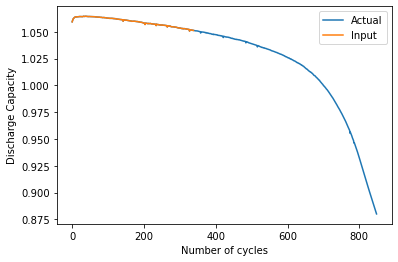

In [9]:
ind = 109

plt.plot(discharge_capacities[ind])
# plt.plot(X_train_padded[ind])
plt.plot(discharge_capacities[ind][0:int(0.4*len(discharge_capacities[ind]))])

# if(ind != cell_with_max_cycle_life):
#     plt.plot(np.pad(Y_train_padded[ind],(list(X_train_padded[ind]).index(-1),0),constant_values=(-1)))
    
# else:
#     plt.plot(np.pad(Y_train_padded[ind],(len(X_train_padded[ind]),0),constant_values=(-1)))
    



plt.legend(['Actual', 'Input', 'Output'])
# plt.title("Input and Output Data")
plt.xlabel("Number of cycles")
plt.ylabel("Discharge Capacity")

In [10]:
import tensorflow as tf
import keras

optimizer = keras.optimizers.Adam(learning_rate=0.01)

def model_plot(model):
    tf.keras.utils.plot_model(model2, to_file='model.png',show_shapes=True,show_dtype=True,show_layer_names=False,
        rankdir='TB',
        expand_nested=False,
        dpi=120,
        layer_range=None,
        show_layer_activations=True
    )
import time
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.perf_counter()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.perf_counter() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()


model = tf.keras.Sequential(name="LSTM")
model.add(keras.layers.LSTM(64, activation="tanh", kernel_initializer='he_uniform', return_sequences=True,batch_input_shape=(None, X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.LSTM(32, activation="tanh",kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
model.add(keras.layers.LSTM(16, activation="tanh",kernel_initializer='he_uniform', return_sequences=True, name='encoder_3'))

model.add(keras.layers.LSTM(16,activation="tanh", kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
model.add(keras.layers.LSTM(32,activation="tanh", kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model.add(keras.layers.LSTM(64,activation="tanh", kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation='sigmoid'))
model.add(keras.layers.Dense(Y_train.shape[1],activation='sigmoid'))

model.compile(loss="mse",optimizer=optimizer)
model.build()


# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.summary()





model2=  tf.keras.Sequential(name="BiLSTM")
model2.add(keras.layers.Bidirectional(keras.layers.LSTM(64, activation="tanh", kernel_initializer='he_uniform',return_sequences=True),batch_input_shape=(None, X_train.shape[1], X_train.shape[2])))
model2.add(keras.layers.Bidirectional(keras.layers.LSTM(32, activation="tanh",kernel_initializer='he_uniform', return_sequences=True, name='encoder_2')))
model2.add(keras.layers.Bidirectional(keras.layers.LSTM(16, activation="tanh",kernel_initializer='he_uniform', return_sequences=True, name='encoder_3')))
# model.add(keras.layers.RepeatVector(50, name='encoder_decoder_bridge'))
model2.add(keras.layers.Bidirectional(keras.layers.LSTM(16,activation="tanh", kernel_initializer='he_uniform', return_sequences=True, name='decoder_1')))
model2.add(keras.layers.Bidirectional(keras.layers.LSTM(32,activation="tanh", kernel_initializer='he_uniform', return_sequences=True, name='decoder_2')))
model2.add(keras.layers.Bidirectional(keras.layers.LSTM(64,activation="tanh", kernel_initializer='he_uniform', return_sequences=True, name='decoder_3')))
# model.add(keras.layers.TimeDistributed(keras.layers.Dense(895)))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(Y_train.shape[1],activation='tanh'))

model2.compile(loss="mse",optimizer=optimizer)
model2.build()
model2.summary()


model3=  tf.keras.Sequential(name='convolution')
model3.add(keras.layers.Conv1D(16,5,batch_input_shape=(None, X_train.shape[1], X_train.shape[2])))
keras.layers.BatchNormalization()
model3.add(keras.layers.MaxPool1D(pool_size=2))
model3.add(keras.layers.Conv1D(32,5))
keras.layers.BatchNormalization()
model3.add(keras.layers.MaxPool1D(pool_size=2))
model3.add(keras.layers.Conv1D(64,5))
keras.layers.BatchNormalization()
model3.add(keras.layers.MaxPool1D(pool_size=2))
model3.add(keras.layers.Conv1D(32,5))
keras.layers.BatchNormalization()
model3.add(keras.layers.MaxPool1D(pool_size=2))
model3.add(keras.layers.Conv1D(16,5))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(100,activation='sigmoid'))
model3.add(keras.layers.Dense(Y_train.shape[1],activation='sigmoid'))

model3.compile(loss="mse",optimizer=optimizer)
model3.build()
model3.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 894, 64)           16896     
                                                                 
 encoder_2 (LSTM)            (None, 894, 32)           12416     
                                                                 
 encoder_3 (LSTM)            (None, 894, 16)           3136      
                                                                 
 decoder_1 (LSTM)            (None, 894, 16)           2112      
                                                                 
 decoder_2 (LSTM)            (None, 894, 32)           6272      
                                                                 
 decoder_3 (LSTM)            (None, 894, 64)           24832     
                                                                 
 flatten (Flatten)           (None, 57216)             0      

In [11]:
timetaken1 = timecallback()
timetaken2 = timecallback()
timetaken3 = timecallback()

history1 = model.fit(X_train,Y_train,epochs = 50, callbacks = [timetaken1], shuffle=True,validation_split = 0.1)


Epoch 1/50
1/3 [=========>....................] - ETA: 28s - loss: 0.2109

KeyboardInterrupt: 

In [ ]:
# history2 = model2.fit(X_train,Y_train,epochs = 50, callbacks = [timetaken2], shuffle=True,validation_split = 0.1)

Epoch 1/200
4/4 [==============================] - 2s 51ms/step - loss: 0.1186
Epoch 2/200
4/4 [==============================] - 0s 46ms/step - loss: 0.0387
Epoch 3/200
4/4 [==============================] - 0s 45ms/step - loss: 0.0331
Epoch 4/200
4/4 [==============================] - 0s 48ms/step - loss: 0.0329
Epoch 5/200
4/4 [==============================] - 0s 41ms/step - loss: 0.0298
Epoch 6/200
4/4 [==============================] - 0s 45ms/step - loss: 0.0269
Epoch 7/200
4/4 [==============================] - 0s 43ms/step - loss: 0.0253
Epoch 8/200
4/4 [==============================] - 0s 45ms/step - loss: 0.0218
Epoch 9/200
4/4 [==============================] - 0s 46ms/step - loss: 0.0198
Epoch 10/200
4/4 [==============================] - 0s 40ms/step - loss: 0.0187
Epoch 11/200
4/4 [==============================] - 0s 35ms/step - loss: 0.0164
Epoch 12/200
4/4 [==============================] - 0s 33ms/step - loss: 0.0156
Epoch 13/200
4/4 [==============================]

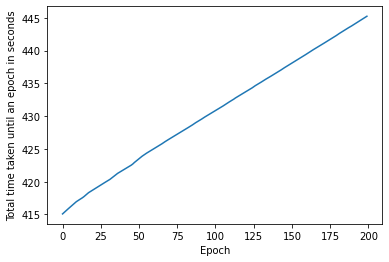

In [ ]:
# history2 = model2.fit(X_train,Y_train,epochs = 50, callbacks = [timetaken2], shuffle=True,validation_split = 0.1)
history3 = model3.fit(X_train,Y_train,epochs = 200, callbacks = [timetaken3], shuffle=True)

In [ ]:
keras.backend.set_epsilon(1)

In [ ]:
out3 = model3.predict(X_test)
out1 = model.predict(X_test)

loss_fn_mse = tf.keras.losses.mean_squared_error
loss_fn_mae = tf.keras.losses.mean_absolute_error
loss_fn_mape = tf.keras.losses.MeanAbsolutePercentageError(
    reduction="auto", name="mean_absolute_percentage_error"
)


print("MSE = {} , MAE ={}, MAPE ={} ".format(np.mean(loss_fn_mse(Y_test, out3)),np.mean(loss_fn_mae(Y_test, out3)) ,np.mean(loss_fn_mape(Y_test, out3))))
print("MSE = {} , MAE ={}, MAPE ={} ".format(np.mean(loss_fn_mse(Y_test, out1)),np.mean(loss_fn_mae(Y_test, out1)) ,np.mean(loss_fn_mape(Y_test, out1))))


1/1 [==============================] - 1s 905ms/step
MSE = 0.0049971770495176315 , MAE =0.03256283327937126, MAPE =3.2562835216522217 
MSE = 0.00369277223944664 , MAE =0.038566991686820984, MAPE =3.856698989868164 


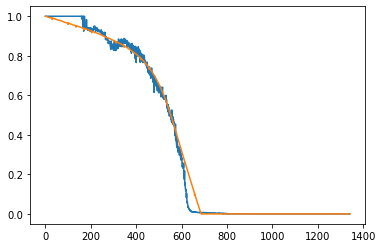

In [ ]:
font = {'family' : 'normal',
        'size'   : 15}
plt.plot(out3[1])
plt.plot(Y_test[1])

1145


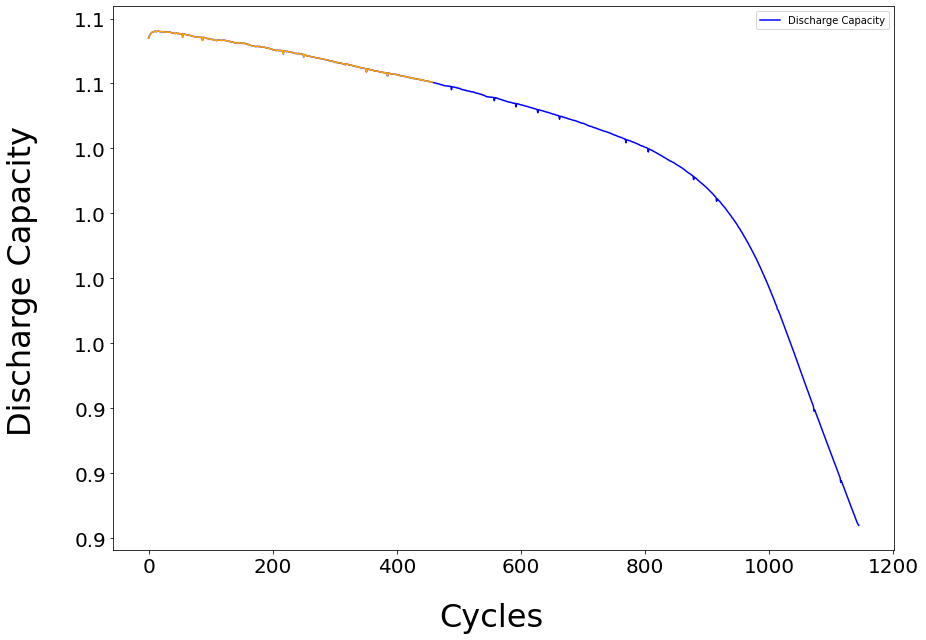

In [ ]:
from matplotlib.ticker import FormatStrFormatter
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}


index = 1
fig, ax = plt.subplots(1,1,figsize=(14,10),sharex=False, sharey=False)

print(len(discharge_capacities[100+index]))
ax.plot(discharge_capacities[100+index], color = "blue")
ax.plot(discharge_capacities[100+index][:int(0.40*len(discharge_capacities[index+100]))],color = "orange")

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
# ax.set_ylabel("Discharge Capacity",font=font)
# ax.set_xlabel("Cycles",font=font)
fig.supxlabel('Cycles',fontsize=32)
fig.supylabel('Discharge Capacity',fontsize=32)
ax.legend(["Discharge Capacity"])
plt.savefig("sample_battery.pdf",dpi=800)

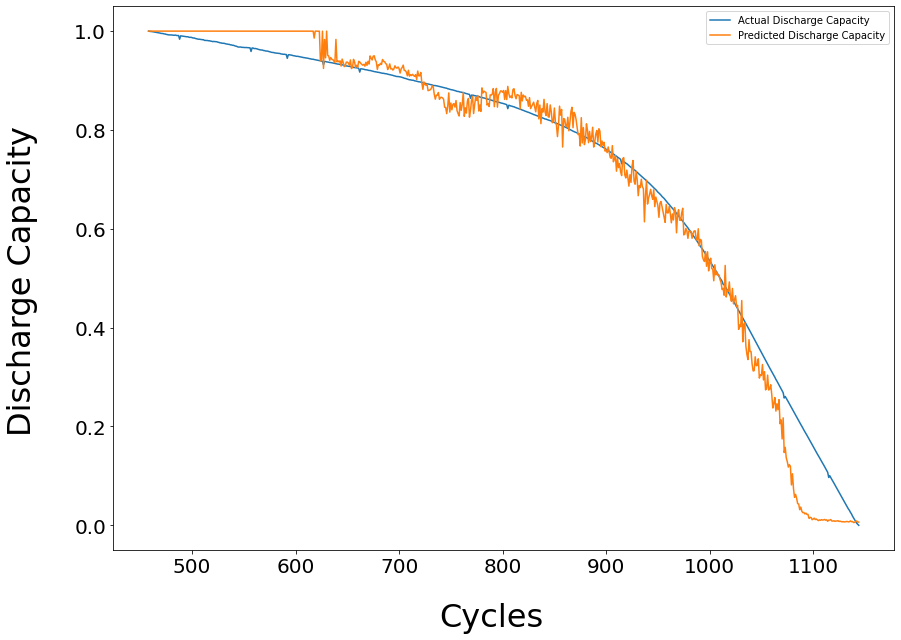

In [ ]:
index = 1

fig, ax = plt.subplots(1,1,figsize=(14,10),sharex=False, sharey=False)
x= [ i for i in range(int(0.4*len(discharge_capacities[100+index])),len(discharge_capacities[100+index]))]

ax.plot(x,Y_test[index][0:int(0.6*len(discharge_capacities[100+index]))])
ax.plot(x,out3[index][0:int(0.6*len(discharge_capacities[100+index]))])
# ax.set_ylabel("Discharge Capacity",font=font)
# ax.set_xlabel("Cycles",font=font)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.legend(["Actual Discharge Capacity","Predicted Discharge Capacity"])
ax.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
fig.supxlabel('Cycles',fontsize=32)
fig.supylabel('Discharge Capacity',fontsize=32)

plt.savefig("sample_prediction.pdf",dpi=800)




0
2


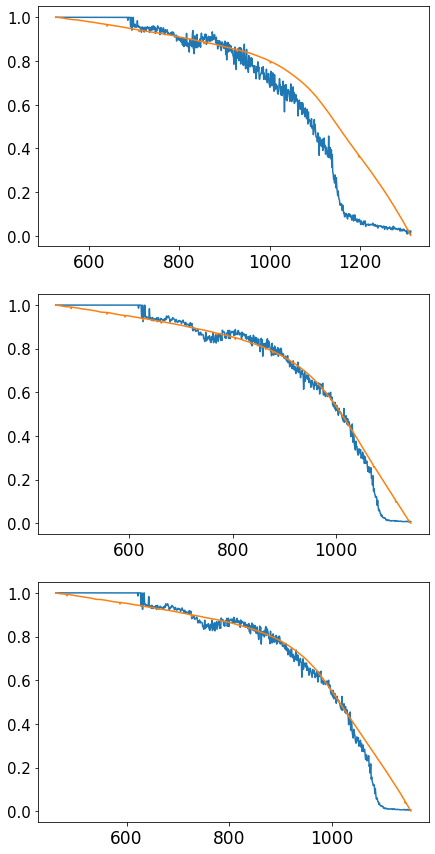

In [ ]:



rows = 3
col  = 1
fig, ax = plt.subplots(rows,col,figsize=(7,15),sharex=False, sharey=False)
ax.flatten()
for ind,index in enumerate([0,1,2]):
    try:
        x= [ i for i in range(int(0.4*len(discharge_capacities[100+index])+1),len(discharge_capacities[100+index]))]
        ax[ind].plot(x,out3[index][0:int(0.6*len(discharge_capacities[100+index]))])
        ax[ind].plot(x,Y_test[index][0:int(0.6*len(discharge_capacities[100+index]))])
        print(ind)
    except:
        x= [ i for i in range(int(0.4*len(discharge_capacities[100+index])),len(discharge_capacities[100+index]))]
        ax[ind].plot(x,out3[index][0:int(0.6*len(discharge_capacities[100+index]))])
        ax[ind].plot(x,Y_test[index][0:int(0.6*len(discharge_capacities[100+index]))])
        
    
    # ax[ind].legend(["Predicted", "Actual"])
    ax[ind].xaxis.set_tick_params(labelsize=17)
    ax[ind].yaxis.set_tick_params(labelsize=15)
    ax[ind].yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    
    # ax[ind].set_xlabel("Cycles", font = font)
    # ax[ind].set_ylabel("Discharge Capacity", font = font)
plt.savefig("CNN_approach.png",dpi=800)


0
2


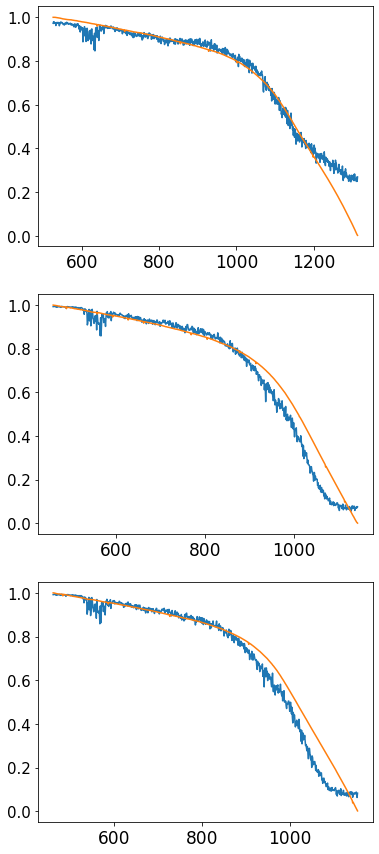

In [ ]:

rows = 3
col  = 1
fig, ax = plt.subplots(rows,col,figsize=(6,15),sharex=False, sharey=False)
ax.flatten()
for ind,index in enumerate([0,1,2]):
    try:
        x= [ i for i in range(int(0.4*len(discharge_capacities[100+index])+1),len(discharge_capacities[100+index]))]
        ax[ind].plot(x,out1[index][0:int(0.6*len(discharge_capacities[100+index]))])
        ax[ind].plot(x,Y_test[index][0:int(0.6*len(discharge_capacities[100+index]))])
        print(ind)
    except:
        x= [ i for i in range(int(0.4*len(discharge_capacities[100+index])),len(discharge_capacities[100+index]))]
        ax[ind].plot(x,out1[index][0:int(0.6*len(discharge_capacities[100+index]))])
        ax[ind].plot(x,Y_test[index][0:int(0.6*len(discharge_capacities[100+index]))])
        
    
    # ax[ind].legend(["Predicted", "Actual"])
    ax[ind].xaxis.set_tick_params(labelsize=17)
    ax[ind].yaxis.set_tick_params(labelsize=15)
    ax[ind].yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    
    # ax[ind].set_xlabel("Cycles", font = font)
    # ax[ind].set_ylabel("Discharge Capacity", font = font)
plt.savefig("LSTM_approach.png",dpi=800)